### Installation

To install `openllmtelemetry` simply use pip:

In [ ]:
%pip install openllmtelemetry[openai]

### Usage

Here's a basic example of how to use **OpenLLMTelemetry** in your project:

First you need to setup a few environment variables to specify where you want your LLM telemetry to be sent, and make sure you also have any API keys set for interacting with your LLM and for sending the telemetry to [WhyLabs](https://whylabs.ai/free?utm_source=openllmtelemetry-Github&utm_medium=openllmtelemetry-example&utm_campaign=WhyLabs_Secure)

In [2]:
import os

os.environ["WHYLABS_API_KEY"] = "replace-with-whylabs-api-key"
os.environ["WHYLABS_DEFAULT_DATASET_ID"] = "replace-with-model-id" #
# os.environ["OPENAI_API_KEY"] = ""  # This example assumes you have an OpenAI key already set

After you verify your env variables are set you can now instrument your app by running the following:

In [6]:
import openllmtelemetry

tracer = openllmtelemetry.instrument()

Once this is done, your interactions with OpenAI LLMs will be automatically traced, like the sample call to OpenAI below:

In [7]:
from openai import OpenAI
client = OpenAI()

response = client.chat.completions.create(
  model="gpt-3.5-turbo",
  messages=[
    {
      "role": "system",
      "content": "You will be provided with a tweet, and your task is to classify its sentiment as positive, neutral, or negative."
    },
    {
      "role": "user",
      "content": "I love lasagna!"
    }
  ],
  temperature=0.7,
  max_tokens=64,
  top_p=1
)

response

ChatCompletion(id='chatcmpl-9HwRSfBlQyDWCScjoQ3wlMTwNZqgc', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='Positive', role='assistant', function_call=None, tool_calls=None))], created=1714063254, model='gpt-3.5-turbo-0125', object='chat.completion', system_fingerprint='fp_3b956da36b', usage=CompletionUsage(completion_tokens=1, prompt_tokens=40, total_tokens=41))

### Integration into application tracing

With open telemetry tracing you can create parent spans and get a rich view of your application interactions as well the LLM specific metrics that `openllmtelemetry` captures. Here is a simple example showing how to explcitly create a trace span above the call to your OpenAI:

In [14]:
def llm(prompt: str) -> str:
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[{
            "role": "system",
            "content": "You will be provided with a tweet, and your task is to classify its sentiment as positive, neutral, or negative."
            },
            {
            "role": "user",
            "content": f"{prompt}"
            }
        ],
        temperature=0.7,
        max_tokens=64,
        top_p=1)
    response_text = response.choices[0].message.content if response.choices else ""
    return response_text

In [15]:
# example code snippet in your LLM Application
print("Ask questions, and when done, enter `q` to quit")
turns = 0
user_prompt = input()
with tracer.start_as_current_span(name="new-chat-thread") as chat_span:
    # you can set your custom span attributes
    chat_span.set_attribute("foo", "bar")
    while user_prompt != 'q':
        response: str = ""
        with tracer.start_as_current_span(name="question") as question_span:
            question_span.set_attribute("conversation.turns", turns)
            response = llm(user_prompt)
        print(response, flush=True)
        print(flush=True)
        user_prompt = input()

Ask questions, and when done, enter `q` to quit
Neutral

Sentiment: Positive

Negative



From this example, you can see what the corresponding traces look like in WhyLabs:

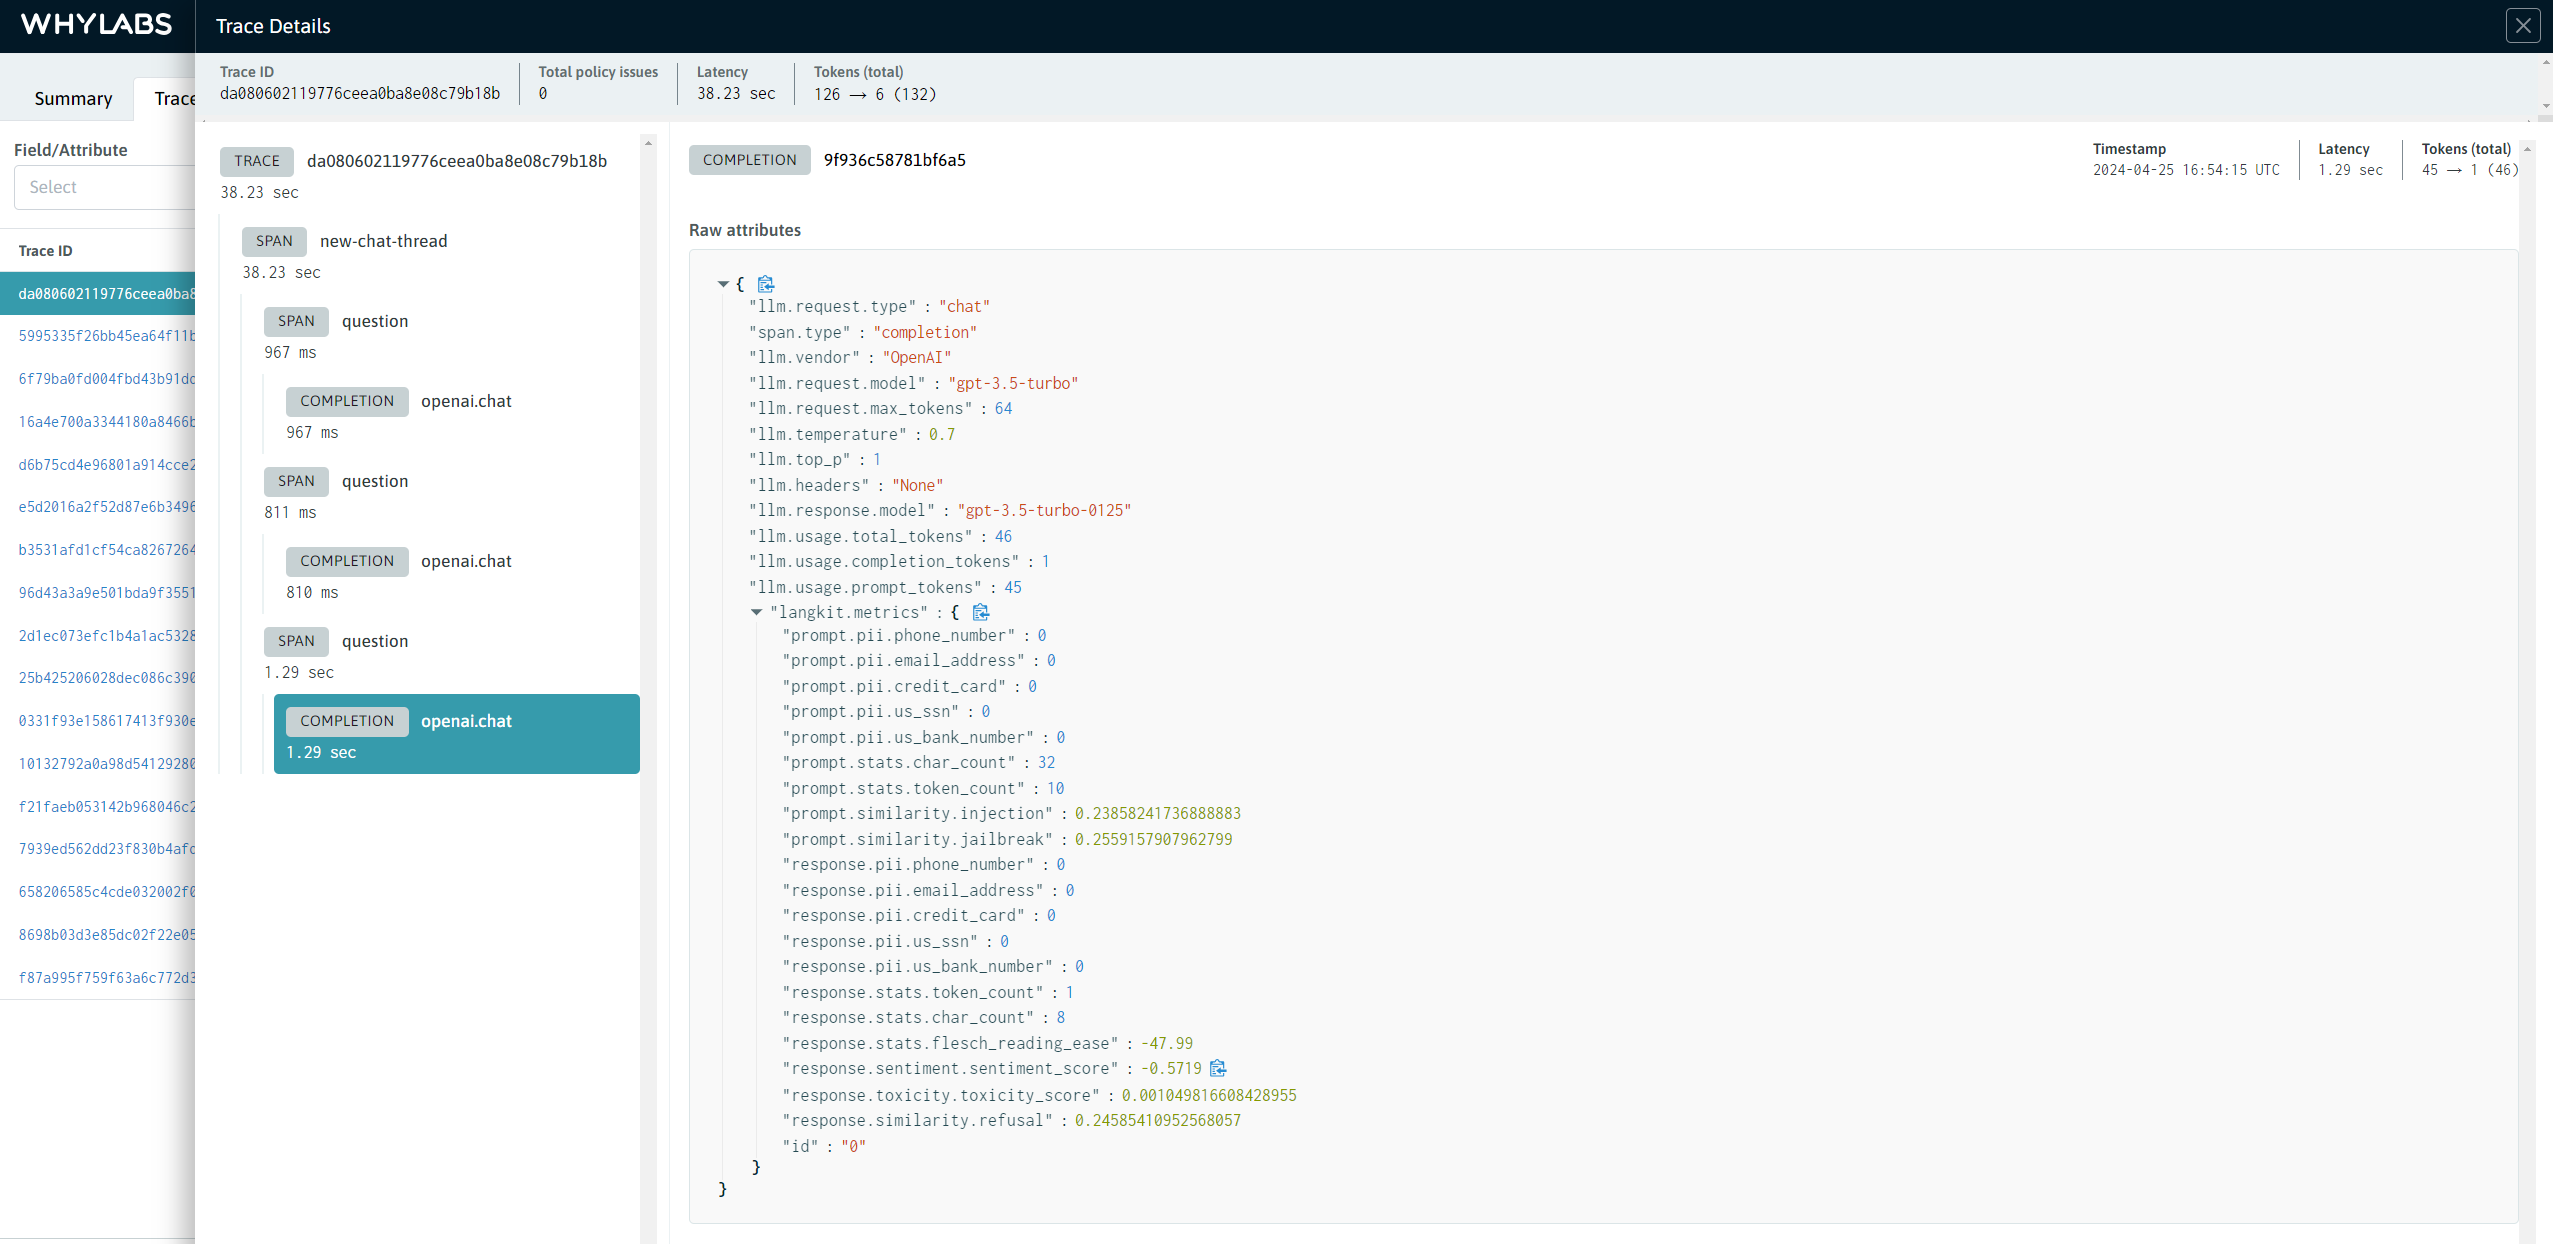